In [34]:
import re
import folium
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from wordcloud import WordCloud, STOPWORDS
from geopy.extra.rate_limiter import RateLimiter

import ipywidgets as widgets
from ipywidgets import Layout

In [12]:
data = pd.read_csv("train.csv")

In [13]:
duplicated_data = data['text'].duplicated().sum()

Existen 110 tweets duplicados


In [14]:
data = data.drop_duplicates(subset=['text'], keep='first')

In [15]:
def clean_data(text):
    text = text.lower()
    text = re.sub(r'http[s]?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'[^A-Za-z0-9 ]+', '', text)
    text = " ".join(text.split())
    return text

In [16]:
def remove_emojis(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE
    )

    return emoji_pattern.sub(r'', text)

In [17]:
data['text'] = data['text'].apply(clean_data)

In [18]:
data['text'] = data['text'].apply(remove_emojis)

In [19]:
data['location'] = data['location'].replace({
    "United States": "USA",
    "London, UK": "UK",
    "Atlanta, GA": "Atlanta",
    "New York City": "New York",
    "NYC": "New York",
    "San Francisco, CA": "San Francisco",
    "California, USA": "California",
    "Chicago, IL": "Chicago",
    "Los Angeles, CA": "Los Angeles",
    "New York, NY": "New York",
    "United Kingdom": "UK",
    "London, England": "London",
    "Everywhere": "Worldwide",
    "Earth": "Worldwide",
    "Washington, DC": "Washington",
    "Washington, D.C.": "Washington"
})

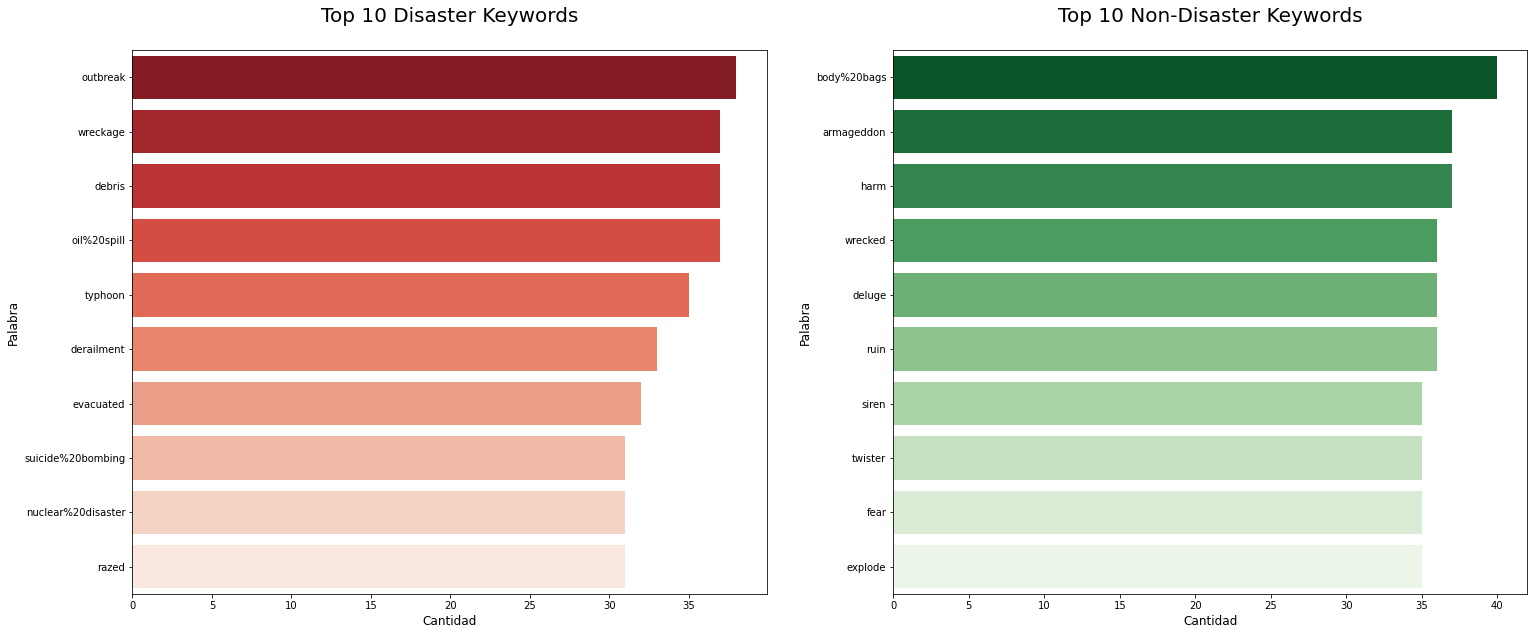

In [24]:
disaster_keywords = data[data['target']==1]['keyword'].value_counts().nlargest(10)
non_disaster_keywords = data[data['target']==0]['keyword'].value_counts().nlargest(10)

fig, ax = plt.subplots(1,2, figsize=(25,10))
sns.barplot(x=disaster_keywords.tolist(), y=disaster_keywords.index, orient='h', palette='Reds_r', ax=ax[0])
sns.barplot(x=non_disaster_keywords.tolist(), y=non_disaster_keywords.index, orient='h', palette='Greens_r', ax=ax[1])

ax[0].set_title('Top 10 Disaster Keywords\n', fontsize=20)
ax[0].set_xlabel('Cantidad', fontsize=12)
ax[0].set_ylabel('Palabra', fontsize=12)

ax[1].set_title('Top 10 Non-Disaster Keywords\n', fontsize=20)
ax[1].set_xlabel('Cantidad', fontsize=12)
ax[1].set_ylabel('Palabra', fontsize=12)
plt.show()

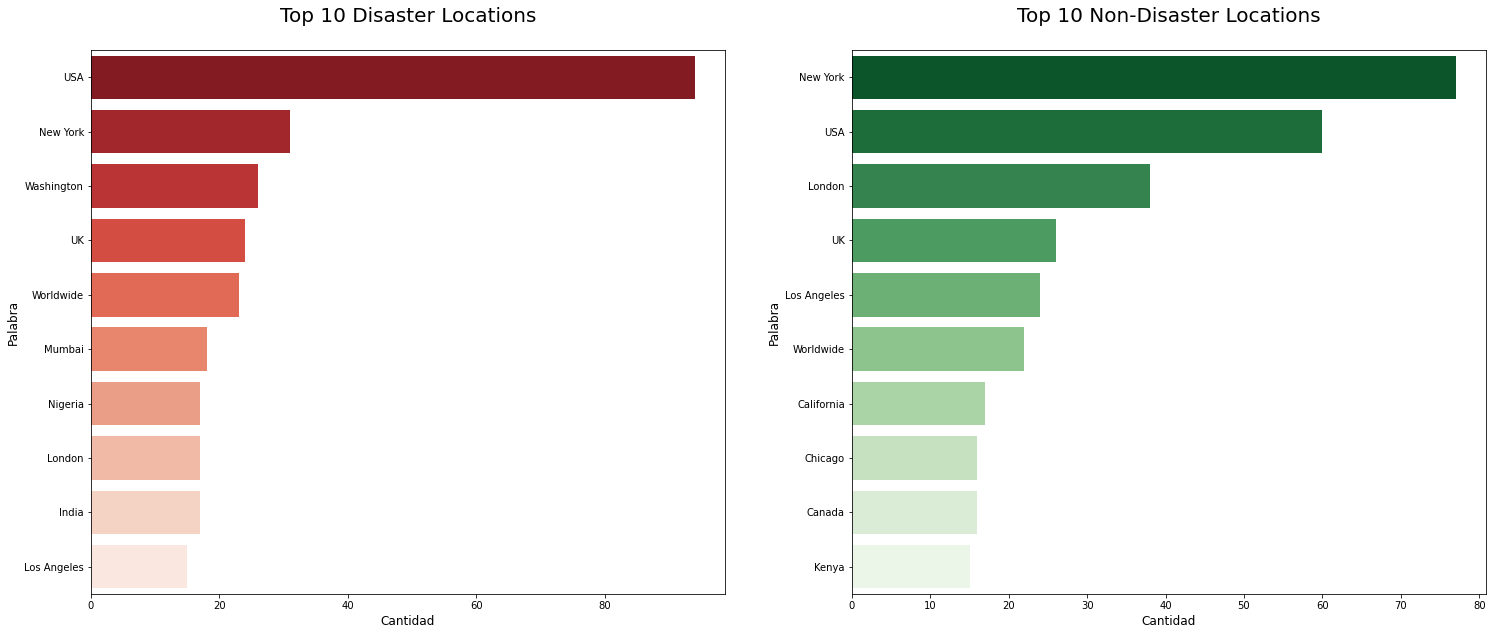

In [26]:
disaster_locations = data[data['target']==1]['location'].value_counts().nlargest(10)
non_disaster_locations = data[data['target']==0]['location'].value_counts().nlargest(10)

fig, ax = plt.subplots(1,2, figsize=(25,10))
sns.barplot(x=disaster_locations.tolist(), y=disaster_locations.index, orient='h', palette='Reds_r', ax=ax[0])
sns.barplot(x=non_disaster_locations.tolist(), y=non_disaster_locations.index, orient='h', palette='Greens_r', ax=ax[1])

ax[0].set_title('Top 10 Disaster Locations\n', fontsize=20)
ax[0].set_xlabel('Cantidad', fontsize=12)
ax[0].set_ylabel('Palabra', fontsize=12)

ax[1].set_title('Top 10 Non-Disaster Locations\n', fontsize=20)
ax[1].set_xlabel('Cantidad', fontsize=12)
ax[1].set_ylabel('Palabra', fontsize=12)
plt.show()

In [27]:
df = data['location'].value_counts()[:20,]
df = pd.DataFrame(df)
df = df.reset_index()
df.columns = ['location', 'counts'] 
geolocator = Nominatim(user_agent="main")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
dictt_latitude = {}
dictt_longitude = {}

for i in df['location'].values:
    location = geocode(i)
    dictt_latitude[i] = location.latitude
    dictt_longitude[i] = location.longitude

df['latitude']= df['location'].map(dictt_latitude)
df['longitude'] = df['location'].map(dictt_longitude)

map1 = folium.Map(location=[10.0, 10.0], tiles='CartoDB dark_matter', zoom_start=2.3)
markers = []

for i, row in df.iterrows():
    loss = row['counts']
    if row['counts'] > 0:
        count = row['counts']*0.4
    folium.CircleMarker([float(row['latitude']), float(row['longitude'])], radius=float(count), color='#ef4f61', fill=True).add_to(map1)

map1

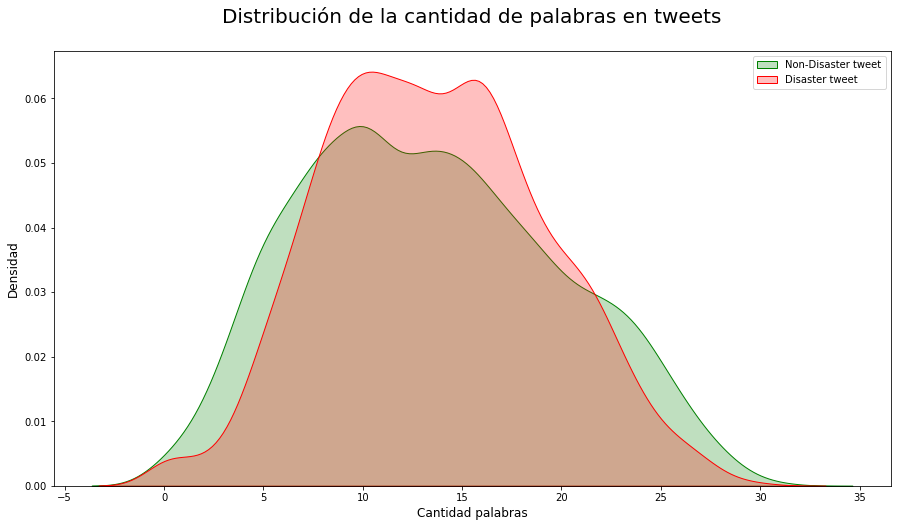

In [29]:
word_count = data['text'].apply(lambda x: len(x.split()))

fig, ax = plt.subplots(figsize = (15, 8))
sns.kdeplot(word_count[data['target'] == 0], shade = True, label = 'Non-Disaster tweet', color='Green')
sns.kdeplot(word_count[data['target'] == 1], shade = True, label = 'Disaster tweet', color='Red')

plt.title('Distribución de la cantidad de palabras en tweets\n', fontsize=20)
ax.legend()
plt.xlabel('Cantidad palabras', fontsize=12)
plt.ylabel('Densidad', fontsize=12)
plt.show()

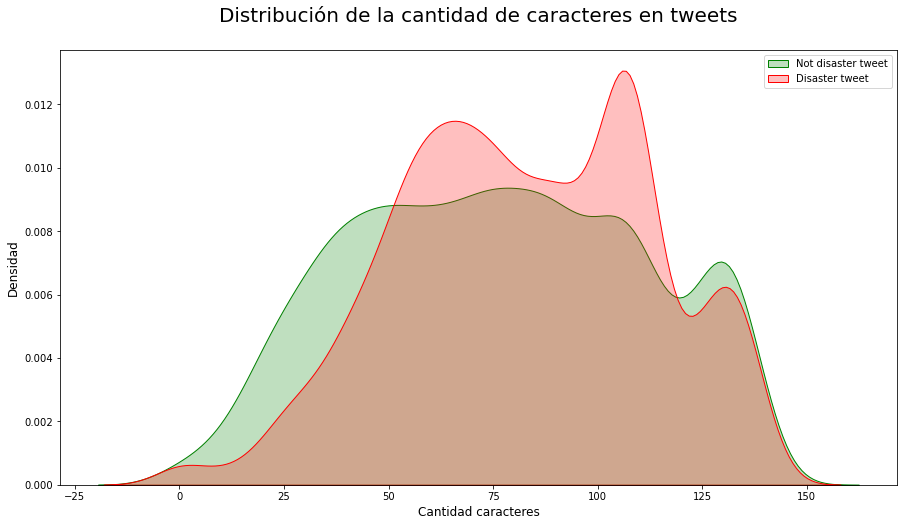

In [30]:
character_count = data['text'].apply(lambda x: len(x))

fig, ax = plt.subplots(figsize = (15, 8))
sns.kdeplot(character_count[data['target'] == 0], shade = True, label = 'Not disaster tweet', color='Green')
sns.kdeplot(character_count[data['target'] == 1], shade = True, label = 'Disaster tweet', color='Red')

plt.title('Distribución de la cantidad de caracteres en tweets\n', fontsize=20)
ax.legend()
plt.xlabel('Cantidad caracteres', fontsize=12)
plt.ylabel('Densidad', fontsize=12)
plt.show()

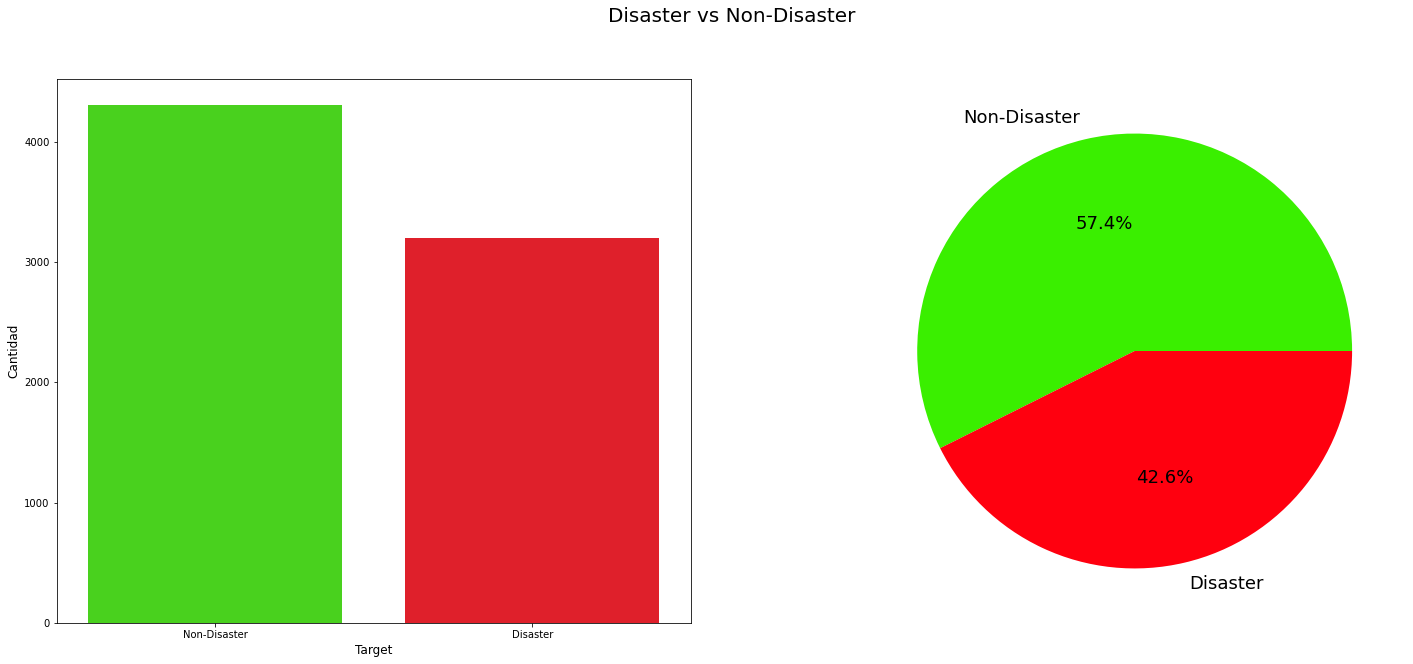

In [31]:
target_values = ['Non-Disaster', 'Disaster']
target = data['target'].value_counts()

fig, ax = plt.subplots(1,2, figsize=(25,10))
fig.suptitle('Disaster vs Non-Disaster', fontsize=20)
colors = sns.color_palette('prism')

sns.barplot(x=target_values, y=target, palette=colors, ax=ax[0])
data.groupby('target').count()['id'].plot(kind='pie', ax=ax[1], labels=target_values, autopct="%.1f%%", colors = colors, fontsize=18)

ax[0].set_xlabel('Target', fontsize=12)
ax[0].set_ylabel('Cantidad', fontsize=12)
ax[1].set_ylabel('')

plt.show()

In [39]:
unique_district = data.keyword.unique()
keyword = widgets.SelectMultiple(
    options = unique_district.tolist(),
    value = ['ablaze', 'accident'],
    description='Keyword',
    disabled=False,
    layout = Layout(width='50%', height='80px', display='flex')
)

In [40]:
keyword

SelectMultiple(description='Keyword', index=(1, 2), layout=Layout(display='flex', height='80px', width='50%'),…

In [43]:
unique_location = data.location.unique()
location = widgets.SelectMultiple(
    options = unique_location.tolist(),
    value = [],
    description='Location',
    disabled=False,
    layout = Layout(width='50%', height='80px', display='flex')
)

In [44]:
location

SelectMultiple(description='Location', layout=Layout(display='flex', height='80px', width='50%'), options=(nan…